# Statistical Modeling of Powerball data
There are three main steps to Statistical modeling:
- Write down the model
  - Prior and likelihood functions
- Compute the Posterior
  - Sampling or Inference
- Check the model
  - Prior Sensitivity
  - Reliability/accuracy in relation to observed data

A powerball ticket has five distinct numbers drawn from 1 to 69, and a sixth "powerball number" drawn independently. Here we are going to model the distribution of the smallest number in the powerball lottery tickets. 

In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
import pandas as pd

## Load dataset
Peek into the data - curiosity helps build intuition
Intuition yields a prior (required for probabilistic modeling).


In [2]:
df_train = pd.read_csv('./pb/pb_asc_x1x5_x6.csv', header=None, names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df_train.head()

,x1,x2,x3,x4,x5,x6
0,16,30,41,48,53,16
1,1,26,41,50,57,11
2,23,33,42,46,59,4
3,2,18,19,22,63,19
4,10,16,40,52,55,17


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e5b2410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111b99050>]], dtype=object)

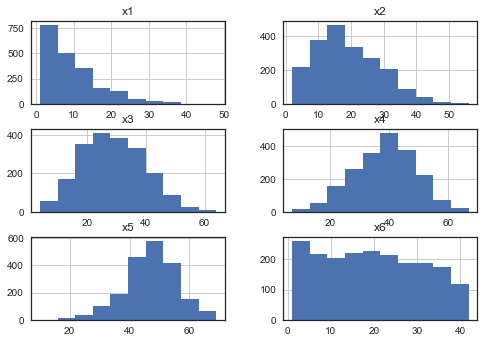

In [3]:
ranges = { i : (df_train[i].min(), df_train[i].max(), df_train[i].max() - df_train[i].min()) for i in df_train.columns}
df_train.hist()

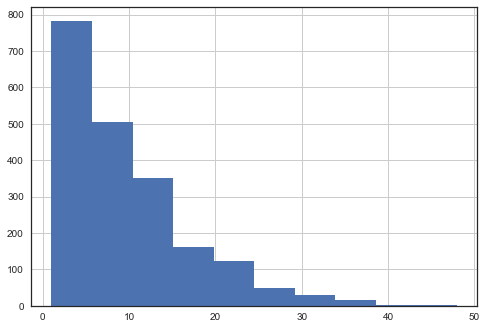

In [4]:
df_train['x1'].hist()

__**That looks like a BetaBinomial discrete distribution with support over a specifiable range (0-47)**__. Use [Wikipedia: List of Probability distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111e03490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1122df750>]], dtype=object)

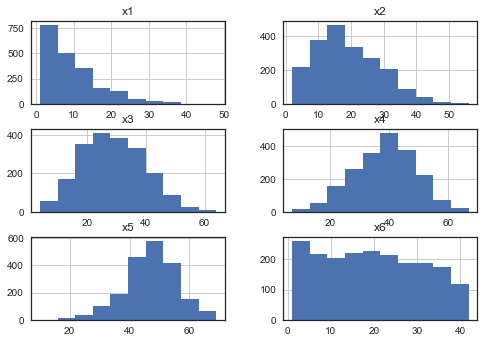

In [5]:
#Now they are all shifted down to zero
df_train.hist()

In [6]:
ranges

{'x1': (1, 48, 47),
 'x2': (2, 56, 54),
 'x3': (4, 64, 60),
 'x4': (7, 67, 60),
 'x5': (10, 69, 59),
 'x6': (1, 42, 41)}

In [7]:
df_train['x3'].min(), df_train['x3'].max(), df_train['x5'].min(), df_train['x5'].max()

(4, 64, 10, 69)

### Step 1 - Build the Model
The likelihood function is assumed to be a BetaBinomial. How did we arrive that? First study a list of probability functions, wikipedia is a great starter source. Then notice that our model has a definite support. What does that mean? That means the variable X1 is defined in a specific range. Also, X1 is discrete. So now one keeps rummaging for distributions that appear to have similar profile as the data we like to model including support and type.
In this case we find that BetaBinomial appears to fit the bill. It is definitely possible that one could other equally feasible probability distributions. In fact, that is part of the adventure of statistical modeling:
- positing the modeling question in interesting ways
- so as to find easily approximateable distributions

In [8]:
X1 = df_train['x1'] - ranges['x1'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.3, upper=2) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta

    # Adjust for 0-based for BetaBinomial distribution
    x1_post = pm.BetaBinomial('x1_post', alpha=alphap, beta=betap, 
                n=ranges['x1'][2], #range for x1
                observed=X1
          ) #Parameterized Likelihood

## Step 2 - Compute the Posterior
This is either done through sampling or inference. In case of MCMC family of sampling, the choices are - Metropolis, HMC, NUTS. 
Variational Inference converts the approximation problem into an optimization problem of minimizing KL Divergence between the posterior and a known suggested distribution _q_. Variational Inference, though was known for decades, recently got a boost from the recent techniques of Automatic Differentiation Variational Inference (ADVI). Variational Inferences are usually rapid, but suffer from accuracy.

Here we use NUTS sampler

100%|██████████| 5500/5500 [00:25<00:00, 217.40it/s]


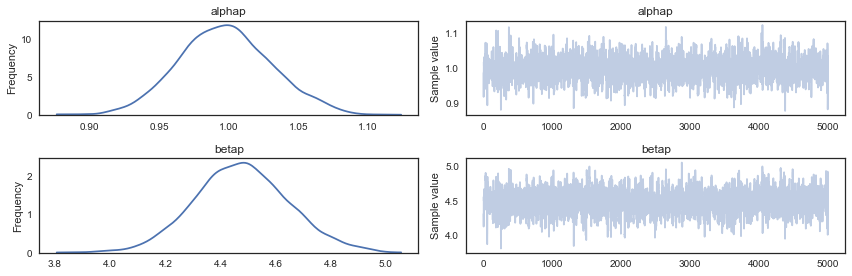

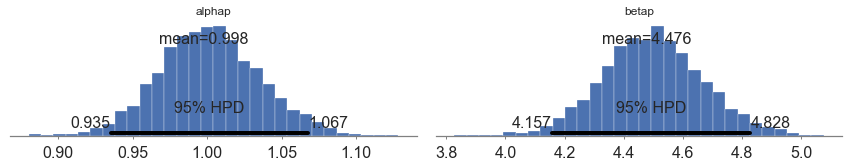

In [9]:
with bb:
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99)) #NUTS sampler, only accept > target
    pm.traceplot(trace) #show me the parameters, alpha
    #pm.energyplot(trace) #the energy plot 
    pm.plot_posterior(trace, varnames=['alphap', 'betap']) #plot the posterior with mean, HPD

In [10]:
#Divergences
trace['diverging'].nonzero()[0].size * 1.0 / len(trace)

0.0

## Step 3 - Check the Model
- Use the Posterior Predictive Check, ppc
- Plot observed and simulated
- Check model sensitivity to prior

In [11]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 3036.86it/s]


### Plot observed and simulated


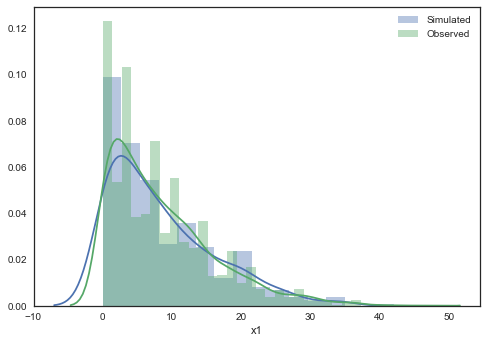

In [12]:
sns.distplot(ppc['x1_post'], label='Simulated')
sns.distplot(X1, label='Observed')
plt.legend()

_Looks quite promising_

### Prior sensitivity
- Same model with different priors (note the use of HalfCauchy and Exponential priors)
- Check the posterior with the previous posterior
- Notice the Highest Posterior Density region of the parameters(HPD)

100%|██████████| 5500/5500 [00:24<00:00, 226.01it/s]


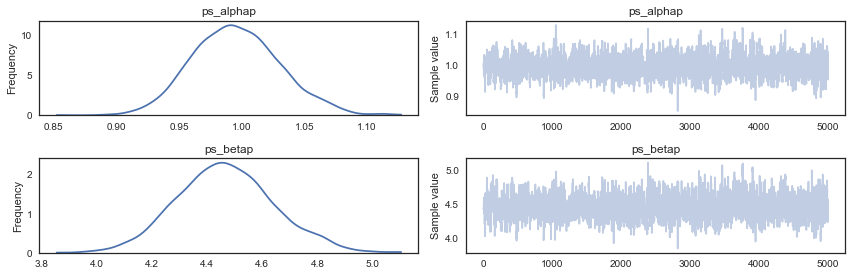

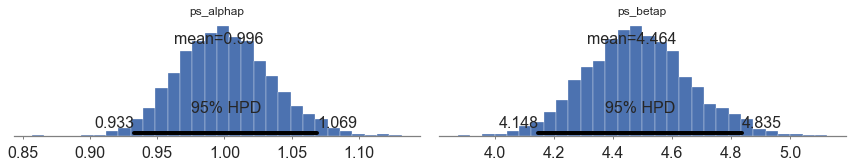

In [13]:
#Prior sensitivity
with pm.Model() as prior_sensitivity:
    alphap = pm.HalfCauchy('ps_alphap', beta=5) #alpha is assumed to be HalfCauchy
    betap = pm.Exponential('ps_betap', lam=.2) #beta is assumed to be exponential
    ps_x1 = pm.BetaBinomial('ps_x1', alpha=alphap, beta=betap, n=ranges['x1'][2], observed=X1)
    ps_trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.traceplot(ps_trace)
    #pm.energyplot(ps_trace)
    pm.plot_posterior(ps_trace, varnames=['ps_alphap', 'ps_betap'])

**__That posterior is the same as the previous one (except for minor numerical precision differences)__**
It further confirms / validates our model.
Now, one could apply the same model for each of x2, x3, x4, and x5, with varying discrete intervals as support.
For x6 we could consider a categorical distribution (or a similar BetaBinomial as for x1-x5).

#### Fit the data for X2

100%|██████████| 5500/5500 [00:27<00:00, 203.31it/s]


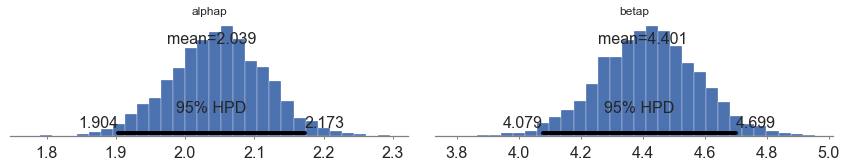

In [14]:
#Adjust for 0-based for BetaBinomial distribution
X2 = df_train['x2'] - ranges['x2'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.4, upper=3) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x2 = pm.BetaBinomial('x2_post', alpha=alphap, beta=betap, n=ranges['x2'][2], 
                         observed=X2) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)

100%|██████████| 500/500 [00:00<00:00, 2839.65it/s]


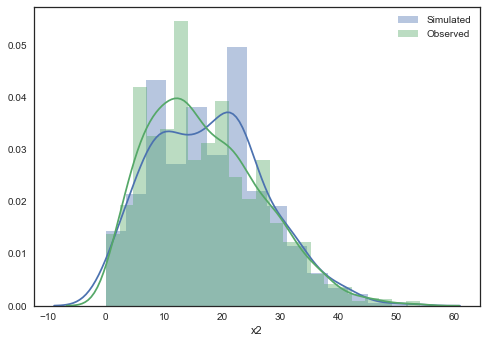

In [15]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)
    sns.distplot(ppc['x2_post'], label='Simulated')
    sns.distplot(X2, label='Observed')
    plt.legend()

_Now that looks like a very good fit_

#### Fit for X3

100%|██████████| 5500/5500 [00:28<00:00, 191.39it/s]


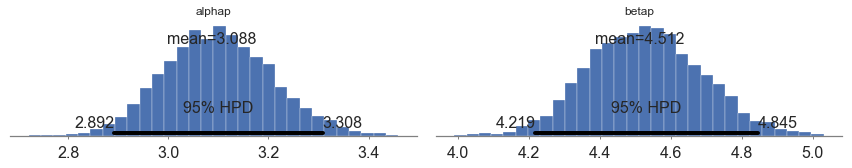

In [16]:
#Adjust for 0-based for BetaBinomial distribution
X3 = df_train['x3'] - ranges['x3'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.4, upper=4) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x3 = pm.BetaBinomial('x3_post', alpha=alphap, beta=betap, n=ranges['x3'][2], 
                         observed=X3) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)

100%|██████████| 500/500 [00:00<00:00, 2613.87it/s]


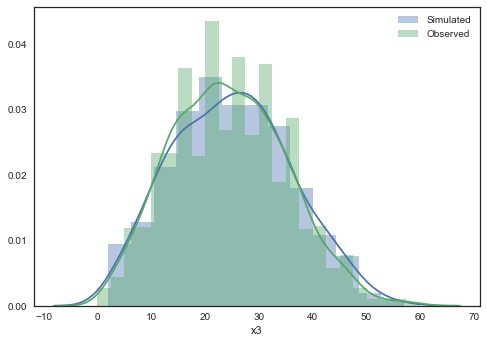

In [17]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)
    sns.distplot(ppc['x3_post'], label='Simulated')
    sns.distplot(X3, label='Observed')
    plt.legend()

#### Fit for X4

100%|██████████| 5500/5500 [00:34<00:00, 157.56it/s]


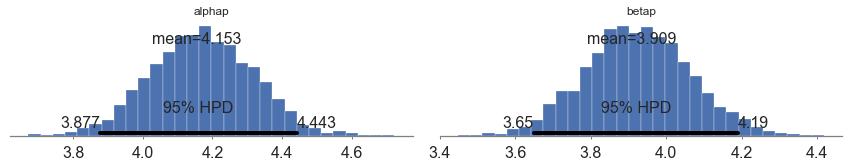

In [18]:
#Adjust for 0-based for BetaBinomial distribution
X4 = df_train['x4'] - ranges['x4'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=0.4, upper=5) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x4 = pm.BetaBinomial('x4_post', alpha=alphap, beta=betap, n=ranges['x4'][2], 
                         observed=X4) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)

100%|██████████| 500/500 [00:00<00:00, 3020.40it/s]


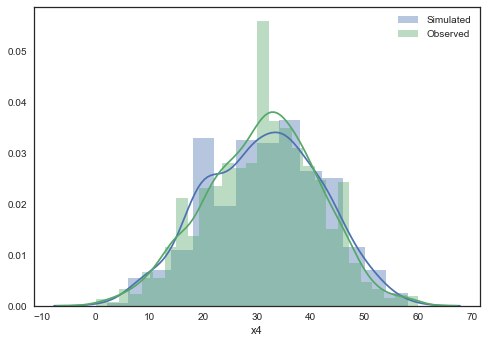

In [19]:
with bb:
    ppc = pm.sample_ppc(trace, samples=500)
    sns.distplot(ppc['x4_post'], label='Simulated')
    sns.distplot(X4, label='Observed')
    plt.legend()

#### Fit for X5

100%|██████████| 5500/5500 [00:30<00:00, 178.03it/s]


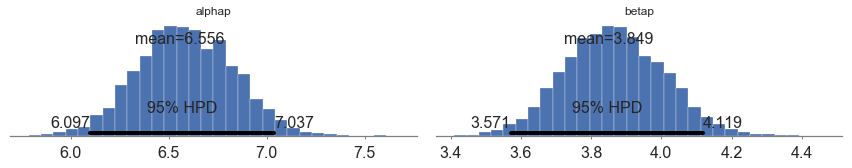

In [20]:
#Adjust for 0-based for BetaBinomial distribution
X5 = df_train['x5'] - ranges['x5'][0]
with pm.Model() as bb:
    alphap = pm.Uniform('alphap', lower=2., upper=8) #prior on the BetaBinomial, alpha
    betap = pm.Uniform('betap', lower=2, upper=8) #beta
    x5 = pm.BetaBinomial('x5_post', alpha=alphap, beta=betap, n=ranges['x5'][2], 
                         observed=X5) #Parameterized Likelihood
    trace = pm.sample(5000, random_seed=7, step=pm.NUTS(target_accept=0.99))
    pm.plot_posterior(trace)

100%|██████████| 1000/1000 [00:00<00:00, 2980.02it/s]


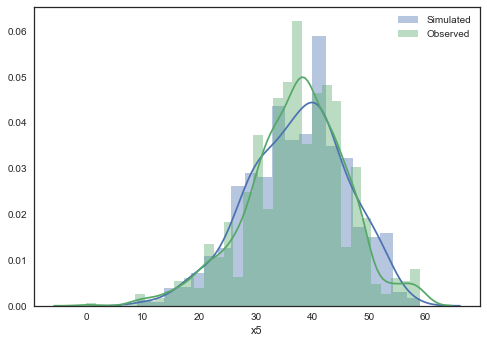

In [21]:
with bb:
    ppc = pm.sample_ppc(trace, samples=1000)
    sns.distplot(ppc['x5_post'], label='Simulated')
    sns.distplot(X5, label='Observed')
    plt.legend()

## Bayesian Neural Network
Now we shall use a neural network based classification model.
The neural net classifies the numbers as '1' or '0'; '1' corresponding to 'X1' and '0' to 'X2'


In [22]:
from sklearn.cross_validation import train_test_split
def prepare_categorical_data(df):
    y_true = pd.Series([True for _ in range(len(X1))], name='TorF')
    y_false = pd.Series([False for _ in range(len(X1))], name='TorF')

    X_yes = pd.concat([df['x1'], y_true], axis=1)
    X_yes.columns = ['Value', 'TorF']

    X_no = pd.concat([df['x3'], y_false], axis=1)
    X_no.columns = ['Value', 'TorF']

    X_Catg = pd.concat([X_yes, X_no], axis=0, ignore_index=True)
    
    #Shuffle
    X_Catg = X_Catg.sample(frac=1).reset_index(drop=True)

    #split - train, test
    X_train, X_test, y_train, y_test = train_test_split(X_Catg['Value'], X_Catg['TorF'], test_size=0.1)
    X_train = np.reshape(X_train, (-1, 1))
    X_test = np.reshape(X_test, (-1, 1))
    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_categorical_data(df_train)

### Plot the training data

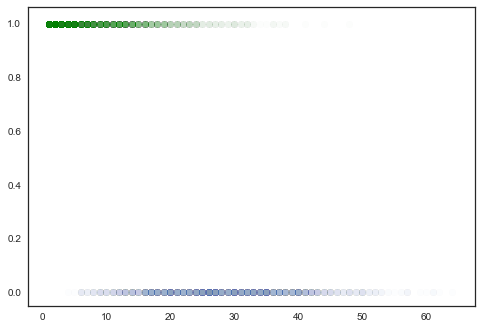

In [23]:
fig, ax = plt.subplots()
ax.scatter(X_train[y_train], y_train[y_train], color='g', alpha=0.01)
ax.scatter(X_train[~y_train], y_train[~y_train], alpha=0.01)

### Define the neural network

In [24]:
ntrain = len(X_train)

#Construct the NN
def construct_nn(nn_in, nn_out):
    n_hidden = 5
    init_1 = np.random.randn(1, n_hidden).astype(theano.config.floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
    init_3 = np.random.randn(n_hidden, 1).astype(theano.config.floatX)
    
    with pm.Model() as bnn:
        weights_1 = pm.Normal('w_1', mu=0, sd=1, shape=(1, n_hidden), testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=1, shape=(n_hidden, n_hidden), testval=init_2)
        weights_3 = pm.Normal('w_3', mu=0, sd=1, shape=(n_hidden, 1), testval=init_3)
        
        #Activations
        act_1 = pm.math.tanh(pm.math.dot(np.log(nn_in), weights_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_2))
        act_3 = pm.math.sigmoid(pm.math.dot(act_2, weights_3))
        out = pm.Bernoulli('Category', p=act_3, observed=nn_out, total_size=ntrain)
        
    return bnn

### Fit the model to data (Inference)
Uses ADVI to compute the posterior distribution of parameters

In [25]:
nn_in = theano.shared(X_train)
nn_out = theano.shared(y_train)
bnn = construct_nn(nn_in, nn_out)
with bnn:
    inference = pm.ADVI()
    approx = pm.fit(50000, method=inference)

Average Loss = 1,573.8: 100%|██████████| 50000/50000 [01:04<00:00, 778.07it/s]
Finished [100%]: Average Loss = 1,574.4


### Plot the posterior parameter distribution from 5000 samples

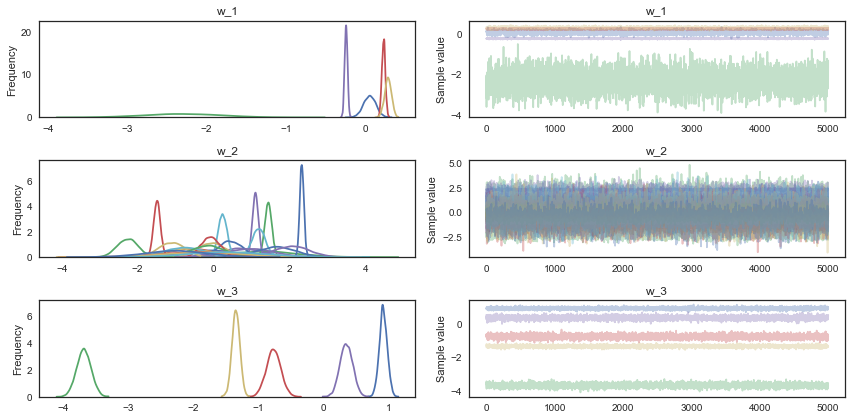

In [26]:
with bnn:
    trace = approx.sample(draws=5000)
    pm.traceplot(trace)

### Plot the learnt boundary against training data

100%|██████████| 500/500 [00:00<00:00, 848.65it/s]


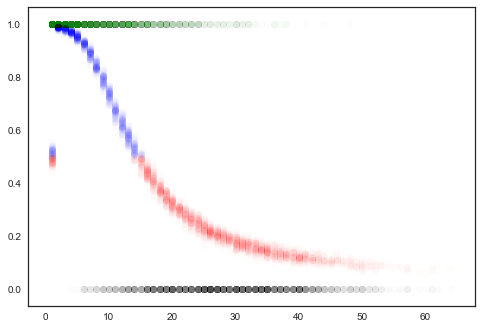

In [27]:
with bnn:
    rpc = pm.sample_ppc(trace, 500)
    rpred = rpc['Category'].mean(axis=0)
    #rproba = rpc['Category'].std(axis=0)
    fig, ax = plt.subplots()
    ax.scatter(X_train[rpred > 0.5], rpred[rpred > 0.5], color='b', alpha=0.01)
    ax.scatter(X_train[rpred <= 0.5], rpred[rpred <= 0.5], color='r', alpha=0.01)
    ax.scatter(X_train[y_train], y_train[y_train], color='g', alpha=0.01)
    ax.scatter(X_train[~y_train], y_train[~y_train], color='k', alpha=0.01)

#### Plot the Evidence Lower Bound (ELBO) maximization history

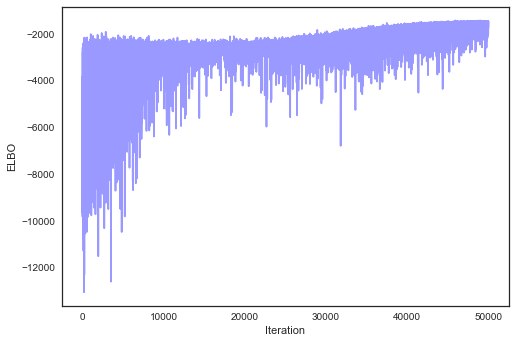

In [28]:
with bnn:
    plt.plot(-inference.hist, label='ADVI', color='b', alpha=0.4)
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')

**__What is the functional form of the neural net?__**
<p>
The neural net computes the probability parameter of a Bernoulli distribution based on a series of non-linearities and affine transformations of the input

In [29]:
bnn.Category.distribution

### Now time to predict (Posterior Predictive Check) 

In [30]:
nn_in.set_value(X_test)
nn_out.set_value(y_test)
with bnn:
    ppc = pm.sample_ppc(trace, 500)
    pred = ppc['Category'].mean(axis=0)
    proba = ppc['Category'].std(axis=0)

100%|██████████| 500/500 [00:00<00:00, 2536.33it/s]


### Plot the predictions

Accuracy: 82.962962963


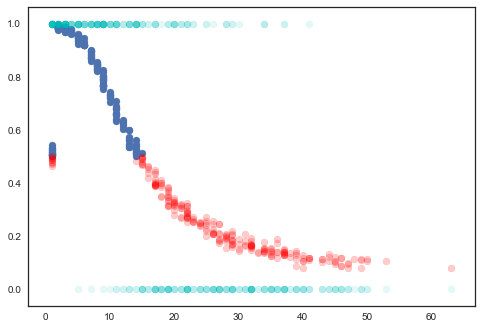

In [31]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred > 0.5], pred[pred > 0.5])
ax.scatter(X_test[pred <= 0.5], pred[pred <= 0.5], color='r', alpha=0.2)
ax.scatter(X_test[y_test], y_test[y_test], color='c', alpha=0.1)
ax.scatter(X_test[~y_test], y_test[~y_test], color='c', alpha=0.1)

print('Accuracy: {}'.format( ( y_test == (pred > 0.5) ).mean() * 100 ))

### Confusion Matrix

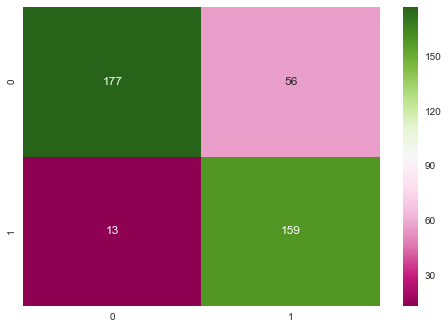

In [32]:
from sklearn.metrics import confusion_matrix
cm = [ 1 if x > 0.5 else 0 for x in pred ]
cnf = confusion_matrix(cm, y_test)
sns.heatmap(cnf, annot=True, fmt='d', cmap='PiYG')

In [33]:
cnf

array([[177,  56],
       [ 13, 159]])

### Now the uncertainty in prediction

<Container object of 3 artists>

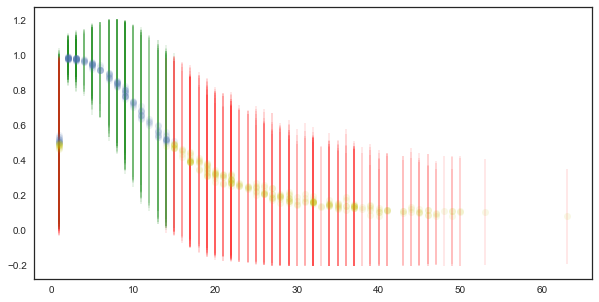

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(X_test[pred > 0.5], pred[pred > 0.5], yerr = proba[pred > 0.5], fmt='o', ecolor='g', capthick=2, alpha=0.1)
ax.errorbar(X_test[pred <= 0.5], pred[pred <= 0.5], yerr = proba[pred <= 0.5], 
            fmt='o', ecolor='r', color='y', capthick=2, alpha=0.1)

## Comparison to a Gaussian Process classifier

In [35]:
%%time
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gp_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
nsize=1000
gp_clf.fit(X_train[:nsize,:], y_train[:nsize,:])
#clf.fit(X_train, y_train)

CPU times: user 3min 52s, sys: 5.46 s, total: 3min 58s
Wall time: 1min


**__Phew.... that took for ever. Especially in comparison to BNN__**

0.849382716049
CPU times: user 2.02 s, sys: 142 ms, total: 2.16 s
Wall time: 623 ms


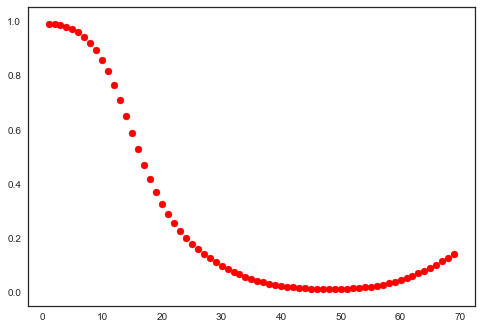

In [36]:
%%time
print gp_clf.score(X_test, y_test)
xx = np.arange(1,70)
pp = gp_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Compare to a random forest classifier

In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf_clf.fit(X_train, y_train)

CPU times: user 66.6 ms, sys: 22.2 ms, total: 88.8 ms
Wall time: 107 ms


0.851851851852
CPU times: user 67.7 ms, sys: 4.29 ms, total: 72 ms
Wall time: 70.6 ms


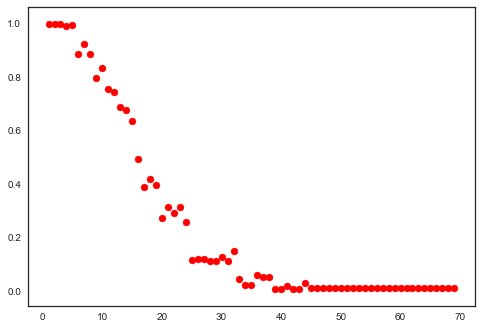

In [38]:
%%time
print (rf_clf.score(X_test, y_test))
xx = np.arange(1,70)
pp = rf_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Compare to AdaBoosted Decision Trees

In [39]:
%%time
from sklearn.ensemble import AdaBoostClassifier
ad_clf = AdaBoostClassifier()
ad_clf.fit(X_train, y_train)

CPU times: user 165 ms, sys: 4.32 ms, total: 170 ms
Wall time: 169 ms


0.851851851852
CPU times: user 70.6 ms, sys: 5.86 ms, total: 76.5 ms
Wall time: 73.4 ms


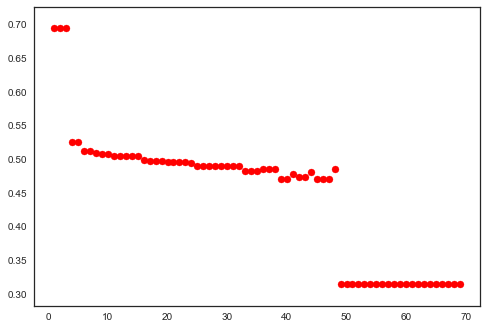

In [40]:
%%time
print (ad_clf.score(X_test, y_test))
xx = np.arange(1, 70)
pp = ad_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Miscellaneous

Assigned Metropolis to betasample
100%|██████████| 10500/10500 [00:02<00:00, 3867.76it/s]


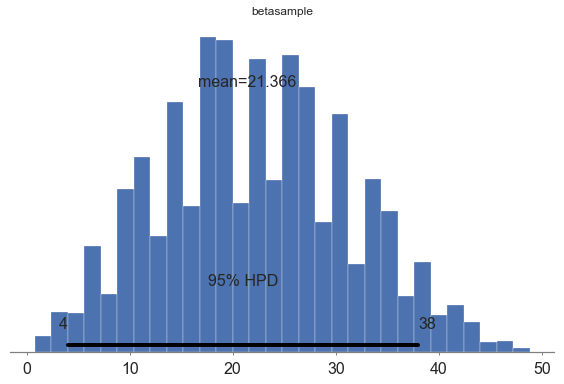

In [41]:
with pm.Model():
    bs = pm.BetaBinomial('betasample', alpha=3., beta=4., n=50)
    bstrace = pm.sample(10000)
    pm.plot_posterior(bstrace)

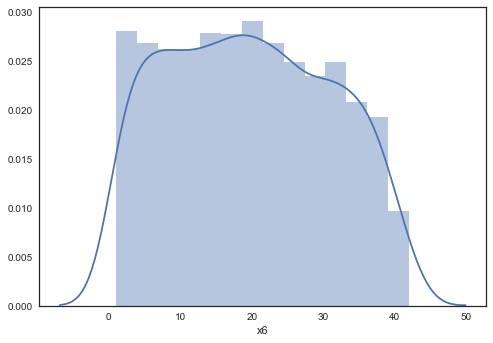

In [42]:
sns.distplot(df_train['x6'])